In [1]:
import spacy
import json
from spacy.training.example import Example
import matplotlib.pyplot as plt

In [2]:
# Load a fresh base model with a full pipeline
nlp = spacy.load("en_core_web_lg")

In [3]:
# Get the NER component
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner", last=True)
else:
    ner = nlp.get_pipe("ner")

In [4]:
# Add the "SKILL" label
ner.add_label("SKILL")

1

In [5]:
# Load your training data.
with open("../data/spacy_training_data.json", "r") as f:
    training_data = json.load(f)

In [6]:
# Prepare training examples.
train_examples = []
for text, annotations in training_data:
    doc = nlp.make_doc(text)
    example = Example.from_dict(doc, annotations)
    train_examples.append(example)

In [7]:
# Track loss values & best model checkpoint
loss_history = []
best_loss = float("inf")
best_epoch = 0

In [8]:
# Identify the pipelines we do NOT want to update (freeze them).
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]

In [9]:
# Use the context manager to disable updates for these components
with nlp.disable_pipes(*other_pipes):
    # Initialize optimizer with lower learning rate
    optimizer = nlp.resume_training()
    optimizer.learn_rate = 0.002  

    for epoch in range(20):  # Training for up to 20 epochs but stopping early if needed
        losses = {}
        nlp.update(train_examples, drop=0.2, sgd=optimizer, losses=losses)
        loss_history.append(losses["ner"])
        print(f"Epoch {epoch+1}, Loss: {losses}")

        # Save best model if loss improves
        if losses["ner"] < best_loss:
            best_loss = losses["ner"]
            best_epoch = epoch + 1
            nlp.to_disk("../models/trained_ner_model_best")

Epoch 1, Loss: {'ner': np.float32(8575.825)}
Epoch 2, Loss: {'ner': np.float32(7401.584)}
Epoch 3, Loss: {'ner': np.float32(6741.118)}
Epoch 4, Loss: {'ner': np.float32(6155.7207)}
Epoch 5, Loss: {'ner': np.float32(5788.16)}
Epoch 6, Loss: {'ner': np.float32(5821.0327)}
Epoch 7, Loss: {'ner': np.float32(5253.595)}
Epoch 8, Loss: {'ner': np.float32(4789.6387)}
Epoch 9, Loss: {'ner': np.float32(6121.8516)}
Epoch 10, Loss: {'ner': np.float32(6436.426)}
Epoch 11, Loss: {'ner': np.float32(6423.696)}
Epoch 12, Loss: {'ner': np.float32(6557.3154)}
Epoch 13, Loss: {'ner': np.float32(6474.543)}
Epoch 14, Loss: {'ner': np.float32(6237.011)}
Epoch 15, Loss: {'ner': np.float32(5720.596)}
Epoch 16, Loss: {'ner': np.float32(4873.644)}
Epoch 17, Loss: {'ner': np.float32(3700.6821)}
Epoch 18, Loss: {'ner': np.float32(2868.891)}
Epoch 19, Loss: {'ner': np.float32(2695.639)}
Epoch 20, Loss: {'ner': np.float32(2347.4688)}


In [10]:
# Save final trained model
nlp.to_disk("../models/trained_ner_model")

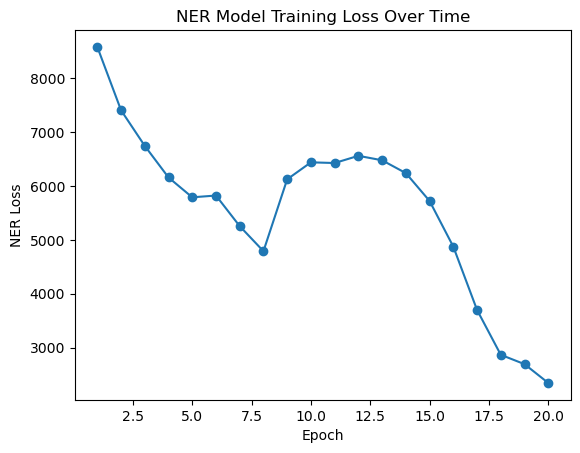

In [11]:
# Plot loss trend
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("NER Loss")
plt.title("NER Model Training Loss Over Time")
plt.show()

In [12]:
print(f"Model training complete! Best model saved at epoch {best_epoch} with loss {best_loss}")
print("Final model saved as 'trained_ner_model'")

Model training complete! Best model saved at epoch 20 with loss 2347.46875
Final model saved as 'trained_ner_model'
